### Imports

In [1]:
%matplotlib widget
%cd ../../..
import logging
# logging.basicConfig(level=logging.INFO)
import os
import re

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from skimage.measure import label
from skimage.metrics import mean_squared_error, normalized_root_mse

from BabelBrain.GPUFunctions.GPULabel import LabelImage

c:\Users\alanc\miniconda3\envs\bbl_dev\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\alanc\OneDrive\Documents\GitHub\BabelBrain


### GPU Initialization

In [2]:
# GPUBackend='CUDA'
GPUBackend='OpenCL'
# GPUBackend='Metal'
gpu_name = '3060'

LabelImage.InitLabel(gpu_name,GPUBackend=GPUBackend)

NVIDIA GeForce RTX 3060
Selecting device:  NVIDIA GeForce RTX 3060


c:\Users\alanc\miniconda3\envs\bbl_dev\lib\site-packages\pyopencl\__init__.py:270: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


### Load Input Data

In [3]:
fname = 'C:/Users/alanc/Documents/NeuroFUS/BabelBrain_Test_Data/SDR_0p55/CT.nii.gz'
base_name,_ = os.path.splitext(os.path.splitext(fname)[0])
nifti=nibabel.load(fname)
data=np.ascontiguousarray(nifti.get_fdata())

### Determine Output Data Resolution

In [4]:
# Set desired spatial step
resolutions = {
    'low_freq_low_ppw': 0.919,    # 200 kHz,   6 PPW
    'low_freq_med_ppw': 0.613,    # 200 kHz,   9 PPW
    'low_freq_high_ppw': 0.459,   # 200 kHz,  12 PPW
    'med_freq_low_ppw': 0.306,    # 600 kHz,   6 PPW
    'med_freq_med_ppw': 0.204,    # 600 kHz,   9 PPW
    'med_freq_high_ppw': 0.153,   # 600 kHz,  12 PPW
    'high_freq_low_ppw': 0.184,   # 1000 kHz,  6 PPW
    'high_freq_med_ppw': 0.123,   # 1000 kHz,  9 PPW
    'high_freq_high_ppw': 0.092,  # 1000 kHz, 12 PPW
}
spatial_step = np.full(3,resolutions['low_freq_low_ppw'])
# spatial_step = np.asarray(nifti.header.get_zooms())/2
spatial_step_text = re.sub("\.","_",str(spatial_step[0]))

# Calculate new affine
zooms = np.asarray(nifti.header.get_zooms())
print(f"Original zooms: {zooms}")
print(f"New zooms: {spatial_step}")
new_x = int(nifti.shape[0]/(spatial_step[0]/zooms[0]))
new_y = int(nifti.shape[1]/(spatial_step[1]/zooms[1]))
new_z = int(nifti.shape[2]/(spatial_step[2]/zooms[2]))
affine_upscaled = affines.rescale_affine(nifti.affine.copy(),
                                         nifti.shape,
                                         spatial_step,
                                         (new_x,new_y,new_z))

# Output dimensions
output_data = np.zeros((new_x,new_y,new_z),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,affine_upscaled)
print(f"Output Dimensions: {output_data.shape}")
print(f"Output Size: {output_data.size}")

Original zooms: [0.44921893 0.449219   0.6255521 ]
New zooms: [0.919 0.919 0.919]
Output Dimensions: (250, 269, 179)
Output Size: 12037750


### Run Resample Step

In [5]:
# Set resample order and mode (default is 3 and 'constant')
order = 3 # 0
mode = 'constant' #'nearest'

resampled_fname = base_name + f"_resampled_CPU_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
if os.path.exists(resampled_fname):
    print('Reloading file')
    resampled_nifti = nibabel.load(resampled_fname)
    resampled_data = np.ascontiguousarray(resampled_nifti.get_fdata())
else:
    print('Generating file')
    resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode=mode,order=order,cval=data.min()) # Truth method
    print('Saving file')
    nibabel.save(resampled_nifti,resampled_fname)
    print('Reloading file')
    resampled_data=np.ascontiguousarray(resampled_nifti.get_fdata())

Reloading file


### Prepare Data

In [6]:
HUCapThreshold = 2100.0
HUThreshold = 300.0
resampled_data[resampled_data>HUCapThreshold]=HUCapThreshold
fct = resampled_data>HUThreshold
nfct = fct > 0.5

### Run Label Step

In [7]:
with CodeTimer("GPU Label", unit="s"):
    data_label_gpu = LabelImage.LabelImage(nfct, GPUBackend=GPUBackend)

with CodeTimer("CPU Label", unit="s"):
    label_truth_fname = base_name + f"_label_CPU_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(label_truth_fname):
        print("Reloading CPU file")
        data_label_cpu = nibabel.load(label_truth_fname).get_fdata()
    else:
        print('Generating CPU file')
        data_label_cpu = label(nfct)
        nifti_label_cpu = nibabel.Nifti1Image(data_label_cpu.astype(np.float32),affine_upscaled)
        print('Saving CPU file')
        nibabel.save(nifti_label_cpu,label_truth_fname)
        
if data_label_gpu.size != data_label_cpu.size:
    print(f"Array sizes don't match: {data_label_gpu.size} vs {data_label_cpu.size}")
if data_label_gpu.size == 0:
    print("Arrays are empty")
if data_label_gpu.dtype != data_label_cpu.dtype:
    print("Arrays have different dtypes")
    data_label_gpu.astype(data_label_cpu.dtype)

Code block 'GPU Label' took: 0.07427 s
Reloading CPU file
Code block 'CPU Label' took: 0.06826 s
Arrays have different dtypes


### Plot Data

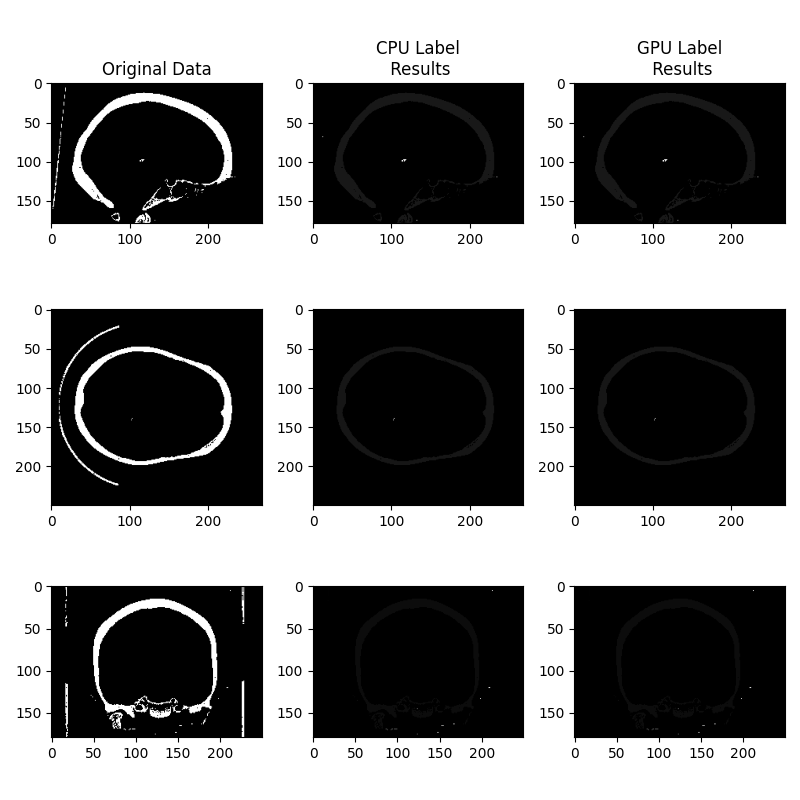

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

slice_num = resampled_data.shape[0]//2
axs[0,0].set_title("Original Data")
axs[0,0].imshow(np.rot90(nfct[slice_num,:,:]), cmap='gray')
axs[0,1].set_title("CPU Label\n Results")
axs[0,1].imshow(np.rot90(data_label_cpu[slice_num,:,:]), cmap='gray')
axs[0,2].set_title("GPU Label\n Results")
axs[0,2].imshow(np.rot90(data_label_gpu[slice_num,:,:]), cmap='gray')

slice_num = resampled_data.shape[2]//2
axs[1,0].imshow(nfct[:,:,slice_num], cmap='gray')
axs[1,1].imshow(data_label_cpu[:,:,slice_num], cmap='gray')
axs[1,2].imshow(data_label_gpu[:,:,slice_num], cmap='gray')

slice_num = resampled_data.shape[1]//2
axs[2,0].imshow(np.rot90(nfct[:,slice_num,:]), cmap='gray')
axs[2,1].imshow(np.rot90(data_label_cpu[:,slice_num,:]), cmap='gray')
axs[2,2].imshow(np.rot90(data_label_gpu[:,slice_num,:]), cmap='gray')

# Adjust plots
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0.1, hspace=0)
plt.tight_layout()

### Check Output Data Matches Truth Data

In [9]:
data_match = np.all(data_label_cpu==data_label_gpu)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(data_label_gpu - data_label_cpu) < 1e-6
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (data_label_cpu.size + data_label_gpu.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(data_label_gpu - data_label_cpu)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))

    slice_num = diffs.shape[0]//2
    axs[0,0].imshow(np.rot90(diffs[slice_num,:,:]), cmap='gray')

    slice_num = diffs.shape[2]//2
    axs[1,0].imshow(diffs[:,:,slice_num], cmap='gray')

    slice_num = diffs.shape[1]//2
    axs[2,0].imshow(np.rot90(diffs[:,slice_num,:]), cmap='gray')

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(data_label_cpu,data_label_gpu)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(data_label_cpu,data_label_gpu,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")

Data matches? True
